In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcdefaults()
import quandl
import pandas as pd
import numpy as np
import functools
import statistics
import math
import os
from datetime import datetime, timedelta
import random
import scipy as sp
import warnings
import gzip
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

# Arjun Kilaru
12212837
## Quantitative Trading Strategies
# Carry Trades

## 1.1 Loading the Data
Here we will load the data from Quandl NASDAQ database.

In [4]:
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key="v2EVM2mpJPBQrcyFbxcH")
    return qdata

In [5]:
raw_data = fetch_quandl(('YC/GBR_ISSC', 'YC/GBR_ISSS'), )
gbrs = raw_data[['YC/GBR_ISSC - 0.08Y', 'YC/GBR_ISSS - 0.08Y']]
gbrs['YC/GBR_ISSC - 0.08Y'] = gbrs['YC/GBR_ISSC - 0.08Y'].fillna(gbrs['YC/GBR_ISSS - 0.08Y'])
gbrs['OIS'] = gbrs['YC/GBR_ISSC - 0.08Y']
gbrs = gbrs[['OIS']]
fx_rates = fetch_quandl(('CUR/GBP', 'CUR/VND', 'CUR/THB', 'CUR/PKR', 'CUR/PHP'), )
fx_rates = fx_rates.loc['2014-12-01':]
fx_rates.columns = ['GBR', 'VNM', 'THA', 'PAK','PHL']
gbrs = gbrs.merge(fx_rates, right_index=True, left_index=True, how='inner')
gbrs = gbrs[['OIS', 'GBR']]

In [6]:
gbrs

,OIS,GBR
2014-12-01,0.426853,0.635521
2014-12-02,0.426426,0.639159
2014-12-03,0.427455,0.637756
2014-12-04,0.427653,0.638112
2014-12-05,0.425867,0.640959
...,...,...
2022-12-12,3.425263,0.817865
2022-12-13,3.454667,0.814212
2022-12-14,3.440270,0.809390
2022-12-15,3.425806,0.806911


In [5]:
yield_curves = fetch_quandl(('YC/VNM', 'YC/THA', 'YC/PAK', 'YC/PHL', 'YC/GBR'), )
yield_curvesGBR = yield_curves[['YC/GBR - 5-Year']]
yield_curves = yield_curves.loc['2014-12-01':]

## 1.2 Plotting the 5 year Yield Curves
In order to visualize the yield possibilities, it may be useful to plot the 5 year yield curves.

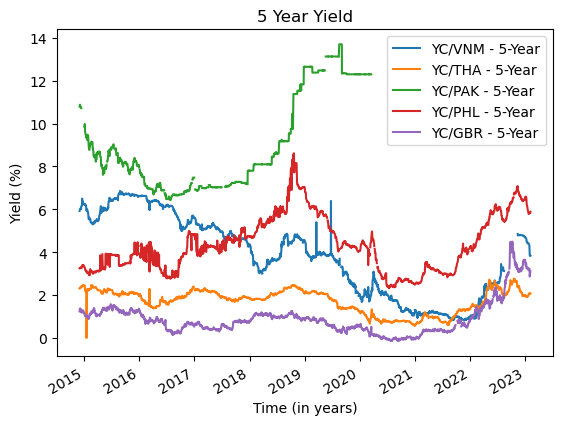

In [133]:
mask = yield_curves.columns.str.contains('5')
yield_curves5 = yield_curves.loc[:, mask]
yield_curves5 = yield_curves5[['YC/VNM - 5-Year', 'YC/THA - 5-Year', 'YC/PAK - 5-Year', 'YC/PHL - 5-Year', 'YC/GBR - 5-Year']]
yield_curves5.plot()
plt.xlabel("Time (in years)")
plt.ylabel("Yield (%)")
plt.title('5 Year Yield')
plt.show()

Clearly, the 5 year yield in Pakistain is the highest, reaching nearly 14% during 2020. The yield in Britain, the currency we are borrowing, is generally the lowest yield, which we expect and prefer given that we borrow that currency, yet the yield of Thai bonds does dip lower after mid-2023. At that point, we will likely not perform carry trades. Additionally, there are a few observed NA values in Pakistan and Vietnam, and those will likely be forward filled to ease computations. 

## 1.3 Plotting the Currency Rates
In order to visualize the fx-related PnL possibilities, it may be useful to plot the cumulative percent changes in FX rate. This view will allow us to see how each exchange rate changes over time. 

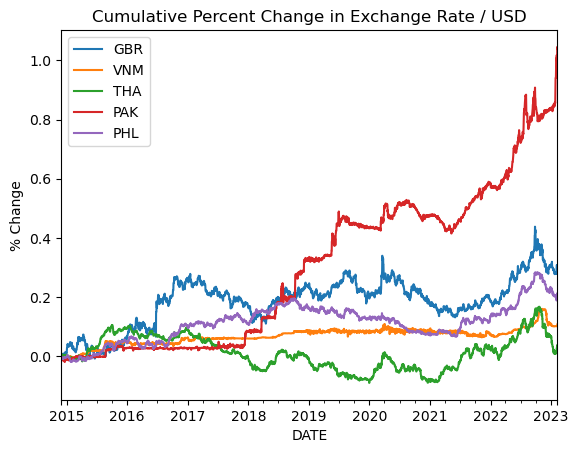

In [138]:
fx_rates.pct_change().cumsum().plot()
plt.ylabel('% Change')
plt.title('Cumulative Percent Change in Exchange Rate / USD')
plt.show()

The most important thing we are looking for here are potential weekly fluctuations, as part of our borrowing and lending PnL comes from the exchange rate differences. Here, we can see that the GBR and PHL rates fluctuate relatively frequently, with a very noise-like plot. For the first three years, the PAK and VNM currencies seem relatively stable, which indicates that fx-related PnL will not be a large contributer in those strategies.

## 2.1 Carry Trade Functions
Following are the functions implemented to execute carry trades from the beginning of Dec 2014 to the end of 2022.

### 2.1.1 Bond Pricing
First, we need functions to compute the zero coupon bond curve given spot rates (which we are using the yield curve as an approximation for). Then, we will implement a function to price the bond given the zero coupon bond curve, a coupon rate, and a tenor.

In [140]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        zcb_rates.index = zcb_rates.index.astype(float)
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if float(tenor) > 0.01:
                times = np.arange(float(tenor)-0.25, 0, step=-0.25)[::-1]
                coupon_quarter = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter*np.exp(-z*times)).sum()
                zcb_rates[curve][float(tenor)] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter))/float(tenor)
    return zcb_rates
    
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

### 2.1.2 Carry Trade: Week View
First, we will write a function to compute the Carry Trade PnL from one week of trading. This function takes in a country and the week's start and end dates. It uses the various yield curve rates and fx rates of that week to determine appropriate pricing and trading notionals. The return is a value of the overall PnL of that week. It is important to note that we have only recievied yield curve data from Pakistan up until 3-19-2020, so after that date, our carry trade will return NaN.

It is also important to note that I won't be adding any lending accrual from the weekly lending, as was indicated by the TA. My only PnL from the lending side is from repricing and selling the bond. 

In [268]:
def carry_trade_one_week(country, date1):
    if country == 'PAK' and date1 > datetime(2020, 3, 19):
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    date2 = date1 + timedelta(days = 6)
    gbrloc = gbrs.ffill().loc[date1:date2]
    gbryield = yield_curvesGBR[date1:date2]
    yieldloc = yield_curves.ffill().loc[date1:date2]
    mask = yieldloc.columns.str.contains(country)
    yieldloc = yieldloc.loc[:, mask]
    if country == 'VNM':
        yieldloc.columns = ['1', '2', '3', '5', '7', '10', '15']
    elif country == 'THA':
        yieldloc.columns = ['0.08', '0.25', '0.5', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '15']
        yieldloc = yieldloc[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '15']]
    elif country == 'PAK':
        yieldloc.columns = ['0.25', '0.5', '1', '3', '5', '10']
        yieldloc = yieldloc[['1', '3', '5', '10']]
    elif country == 'PHL':
        yieldloc.columns = ['0.08', '0.25', '0.5', '1', '2', '3', '4', '5', '7', '10', '20', '25']
        yieldloc = yieldloc[['1', '2', '3', '4', '5', '7', '10', '20', '25']]
        
    spot_rates_curve = yieldloc.copy().T
    
    fxloc = fx_rates.ffill().loc[date1:date2]
    mask = fxloc.columns.str.contains(country)
    fxloc = fxloc.loc[:, mask]
    
    if yieldloc['5'][0] - gbryield.iloc[0,0] < 0.5:
        return (0, 0, 0, 0, 0, 0)
    
    notional = 10000000 #in usd 
    leverage = 0.8 * notional

    foreign_money = notional * fxloc.iloc[0,0] 
    leverage_in_gbp = leverage * gbrloc.iloc[0,1]

    #lend at foreign - buy 10M worth of foreign bonds
    spot_rates_curve = spot_rates_curve.multiply(0.01)
    zcbs = compute_zcb_curve(spot_rates_curve)
    bond_price_old = bond_price(zcbs[zcbs.columns[0]], spot_rates_curve.loc['5', zcbs.columns[0]], tenor = 5)
    bond_price_new = bond_price(zcbs[zcbs.columns[0]], spot_rates_curve.loc['5', zcbs.columns[0]], tenor = 5-(1/52))
    
    #week passes

    lend_accrual = (foreign_money * yieldloc.loc[zcbs.columns[0], '5'] * 0.01 * 1/52)/fxloc.iloc[-1,-1] #apparently, we don't use this anymore
    lend_new_value = notional * (bond_price_new / bond_price_old) * (fxloc.iloc[0,0]/fxloc.iloc[-1,-1])
    lend_pnl = lend_new_value - notional #+ lend_accrual
    
    borrow_pnl = (-leverage_in_gbp * ((gbrloc.iloc[0,0] * 1/52 * 0.01) + 0.005*1/52))*(1/gbrloc.iloc[-1,-1])
    money = borrow_pnl + lend_pnl
    
    accrual_pnl_nofx = notional * yieldloc.loc[zcbs.columns[0], '5'] * 0.01 * 1/52
    sell_pnl_nofx =  notional * (bond_price_new / bond_price_old) - notional
    fx_pnl1 = (lend_accrual - accrual_pnl_nofx) + lend_new_value - sell_pnl_nofx - notional
    
    
    borrow_pnl_no_fx = -leverage * ((gbrloc.iloc[0,0] * 1/52 * 0.01) + 0.005*1/52)
    fx_pnl2 = borrow_pnl - borrow_pnl_no_fx
    
    return (money, sell_pnl_nofx , accrual_pnl_nofx , fx_pnl1 , borrow_pnl_no_fx ,fx_pnl2)

### 2.1.2 Carry Trade: Backtest
Here is the execution of carry trading across all weeks. The return is a DataFrame with Gross PnL, Cumulative PnL, and Cumulative Returns. The only input is the country (code specified by Quandl YC) and the corresponding returns will be calculated using the dataframes above.

In [304]:
def carry_trade(country):
    switch = False
    date1 = datetime(2014, 12, 1)
    df = []
    sell_pnl_nofx = []
    accrual_pnl_nofx = []
    fx_pnl = []
    borrow_pnl_no_fx = []
    dates = []
    x = pd.DataFrame()
    while not switch:
        if date1 == datetime(2022, 12, 12):
            switch = True # break the loop
        date2 = date1 + timedelta(days = 6)
        pnl = carry_trade_one_week(country, date1)
        try:
            sell_pnl_nofx.append(pnl[1])
            accrual_pnl_nofx.append(pnl[2])
            fx_pnl.append(pnl[3] + pnl[5])
            borrow_pnl_no_fx.append(pnl[4])
            df.append(pnl[0])
        except:
            sell_pnl_nofx.append(np.nan)
            accrual_pnl_nofx.append(np.nan)
            fx_pnl.append(np.nan)
            borrow_pnl_no_fx.append(np.nan)
            df.append(np.nan)
        dates.append(date1)
        date1 = date2 + timedelta(days = 1)
    x.index = dates
    x['Gross Pnl'] = df
    x['Sell Pnl Frac'] =  sell_pnl_nofx
    x['FX Pnl Frac'] =  fx_pnl
    x['Borrow Pnl Frac'] =  borrow_pnl_no_fx
    x['Accrual Pnl Frac'] =  accrual_pnl_nofx
    x['Cum Pnl'] = x['Gross Pnl'].cumsum()
    x['Returns'] = x['Gross Pnl']/2000000
    x['Cum Ret'] = (x['Cum Pnl'])/2000000
    return x

In [305]:
a = carry_trade('PAK')
b = carry_trade('VNM')
c = carry_trade('PHL')
d = carry_trade('THA')

## 3.1 Analysis
We will analyze the performance of carry trade strategies across countries, compute relevant metrics, and compare with benchmark returns.

### 3.1.1 Graphical Analysis 

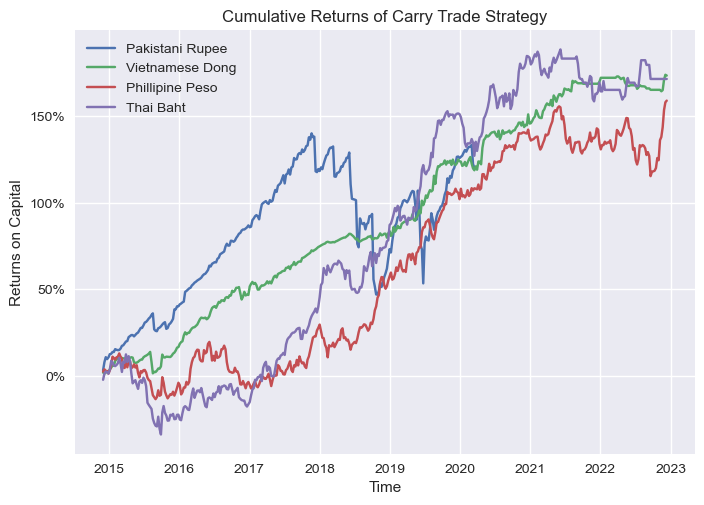

In [306]:
import matplotlib
import matplotlib.ticker as ticker
matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(a.index, a['Cum Ret'], label = 'Pakistani Rupee')
ax.plot(b.index, b['Cum Ret'], label = 'Vietnamese Dong')
ax.plot(c.index, c['Cum Ret'], label = 'Phillipine Peso')
ax.plot(d.index, d['Cum Ret'], label = 'Thai Baht')
plt.title('Cumulative Returns of Carry Trade Strategy')
ax.legend()
plt.xlabel("Time")
plt.ylabel("Returns on Capital")
formatter = ticker.PercentFormatter(xmax=1)
ax.yaxis.set_major_formatter(formatter)
plt.show()

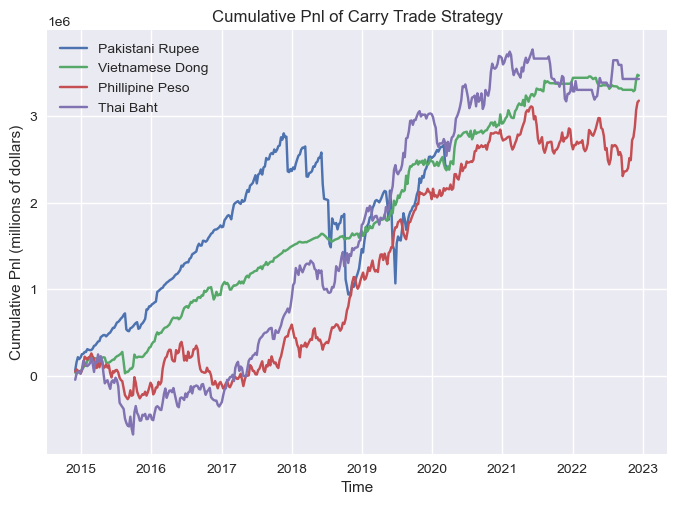

In [307]:
matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(a.index, a['Cum Pnl'], label = 'Pakistani Rupee')
ax.plot(b.index, b['Cum Pnl'], label = 'Vietnamese Dong')
ax.plot(c.index, c['Cum Pnl'], label = 'Phillipine Peso')
ax.plot(d.index, d['Cum Pnl'], label = 'Thai Baht')
plt.title('Cumulative Pnl of Carry Trade Strategy')
ax.legend()
plt.xlabel("Time")
plt.ylabel("Cumulative Pnl (millions of dollars)")
plt.show()

The cumulative returns and PnL for each strategy are shown above. Each strategy ends with positive returns, with the Baht, Dont, and Peso strategy especially generating roughly 150% cumulative returns on the initial $2M initial capital.

Now, we will analyze the different distributions of returns to see if there is any skew or discrepancy in the weekly returns.

IndexError: index 4 is out of bounds for axis 0 with size 4

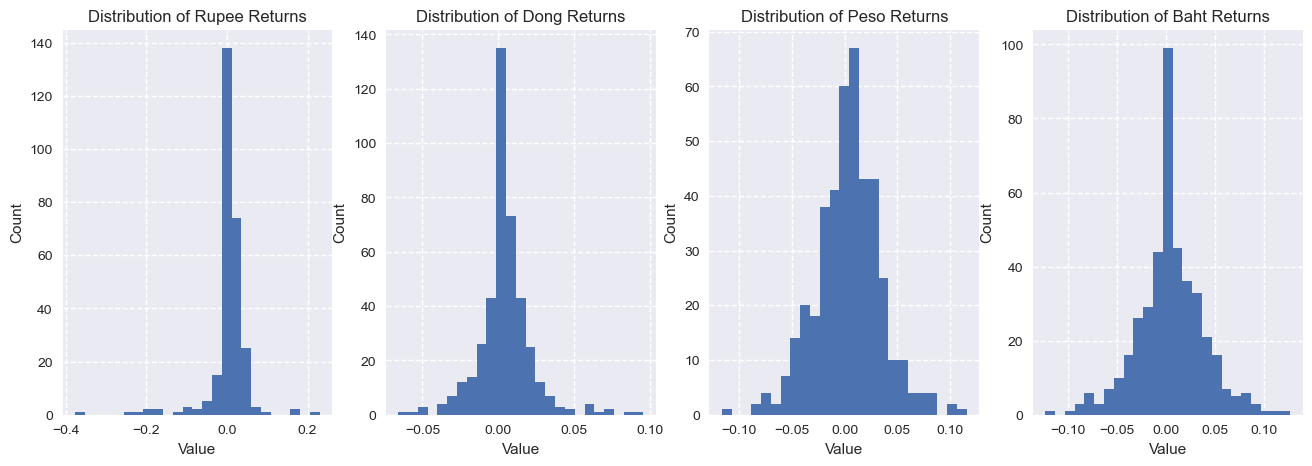

In [344]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
for i, col in enumerate(returns.columns):
    returns[col].plot(kind="hist", ax=ax[i], title=f"Distribution of {col} Returns", bins=25)
    ax[i].grid(linestyle='--')
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Count")
# Showing the plot
plt.show()

Here, we can see that each currency has weekly returns that are approximately unimodal, symmetric, and normal in distribution with a center roughly above zero. These returns can be presented annualized, but the shapes would be the same nonetheless. Ultimately, each strategy does not create significantly skewed returns, save for the rupee returns, which appear very slightly left skewed. This was also showcased in the explicit calculation of skewness which will be shown below. 

### 3.1.2 Metric Analysis
It may be useful to analyze explicit metrics that can be calculated from our dataset of returns. We will look at performance and risk-related metrics.

In [273]:
def performanceMetrics(returns):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * 52
    metrics['Vol'] = returns.std() * np.sqrt(52)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(52)
    return metrics

returns = pd.DataFrame()
returns['Rupee'] = a['Returns']
returns['Dong'] = b['Returns']
returns['Peso'] = c['Returns']
returns['Baht'] = d['Returns']
performanceMetrics(returns)

,Mean,Vol,Sharpe
Rupee,0.225934,0.360127,0.627373
Dong,0.214866,0.127783,1.681492
Peso,0.196923,0.223112,0.882618
Baht,0.212423,0.244655,0.868255


In [274]:
def tailRisk(returns):
    metrics = pd.DataFrame(index = returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis() - 3
    metrics['VaR (5th)'] = returns.quantile(.05)
    metrics['CVaR (5th)'] = (returns[returns < returns.quantile(.05)]).mean()
    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics
tailRisk(returns)

,Skewness,Kurtosis,VaR (5th),CVaR (5th),Min,Max
Rupee,-2.806999,17.053998,-0.049882,-0.157702,-0.377585,0.230510
Dong,0.712087,2.150074,-0.023955,-0.035510,-0.065942,0.095676
Peso,-0.033314,-1.908113,-0.049040,-0.063987,-0.116578,0.116008
Baht,-0.025433,-1.765110,-0.052659,-0.074016,-0.122778,0.126765


The annualized return, volatility, and sharpe (taken from the gross returns as opposed to cumulative), are shown above. Each currency had expected annualized returns that were higher than 19%. Furthermore, Each currency trading strategy has an annual rate of return higher than the 5y treasury rate, which we can use as the risk-free rate. Each has a volatility of over 0.12, meaning 12% return volatility annualized. The Dong strategy  has a sharpe ratio higher than 1.6, which indicates an acceptable strategy by general investor standards (according to the Internet). Overall, each strategy performed well my most investor standards (at least by my standarads). 

Regarding the tail risk statistics, the Peso and Baht returns has negative kurtosis, indicating a more spread out distribution without the presence of many peaks. The Dong and Rupee strategies had a positive kurtosis, indicating the presence of returns that are more concentrated aroun the mean, along with the presence of peaks. Nearly all returns had a negative skew, which indicates left-skewed distribution, as each cumulative return increases with time and the distributions reflect more positive returns with few negative outliers. 

The percentile, min, and max statistics provide further information on the range of distributions. Each strategy had a weekly return range that was greater than 0.1 with the Rupee strategy having a range of almost 60% on a weekly basis. 

### 3.1.3 PnL Breakdown by Revenue Channel
It may be useful to assess which elements of the carry trade creates the most PnL. By mapping the various factors that contribute to overall PnL, we can gain insight on where the most money is made or lost, and perhaps adjust our strategy accordingly, if that is possible. For the Dong and Peso carry trades, let's map the PnL breakdown. 

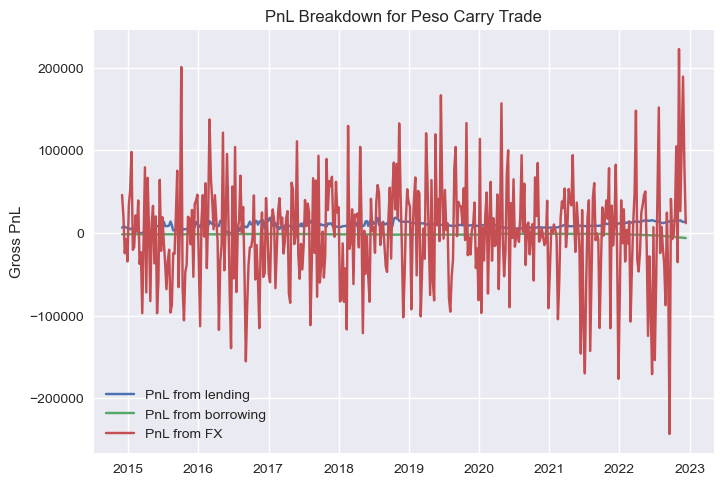

In [301]:
fig, ax = plt.subplots()
ax.plot(c['Sell Pnl Frac'], label  =  'PnL from lending')
ax.plot(c['Borrow Pnl Frac'], label = 'PnL from borrowing')
ax.plot(c['FX Pnl Frac'], label = 'PnL from FX')
plt.ylabel('Gross PnL')
plt.title('PnL Breakdown for Peso Carry Trade')
plt.legend()

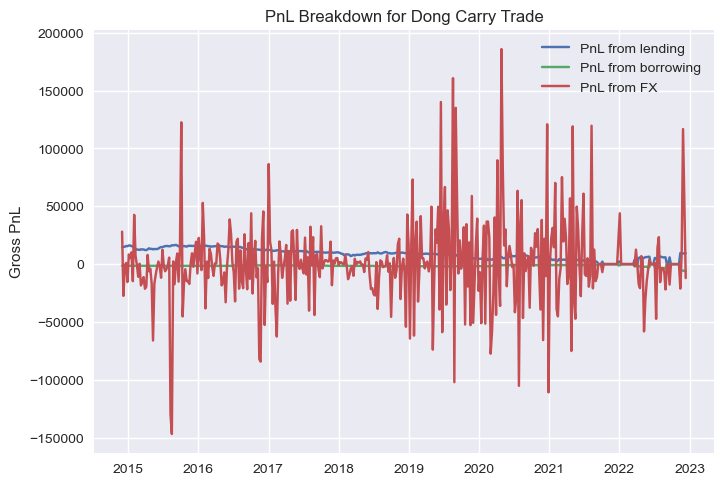

In [303]:
fig, ax = plt.subplots()
ax.plot(b['Sell Pnl Frac'], label  =  'PnL from lending')
ax.plot(b['Borrow Pnl Frac'], label = 'PnL from borrowing')
ax.plot(b['FX Pnl Frac'], label = 'PnL from FX')
plt.ylabel('Gross PnL')
plt.title('PnL Breakdown for Dong Carry Trade')
plt.legend()

It is clear that the weekly differences in PnL very largely come as a result of FX PnL, meaning that changes in the FX rate from the beginning of the week to the ehnd of the week typically hold the most significant weight in the overall PnL. This makes sense, as we are converting up to ten million dollars on a weekly basis, so small changes in the FX rate can certainly result in large swings in PnL. From lending, there is a roughly constant weekly PnL in both cases with no major fluctuations. With borrowing, there is also a very small negative PnL that also appears roughly constant. If we would like to stabilize our returns more, we can use this information to perhaps consider a country with a very stable exchange rate, although I am not quite sure an one like that exists.

### 3.1.4 Correlation Analysis: Currencies

It may be important to assess the correlation of returns among currencies, which may present important for diversifying or hedging purposes. 

In [323]:
returns_pak = returns.loc[:'2020-03-19']
corpak = returns_pak.corr()
rets = returns.copy()
del rets['Rupee']
correlations = rets.corr()
correlations['Rupee'] = 0
correlations.iloc[0,3] = corpak.iloc[0,1]
correlations.iloc[1,3] = corpak.iloc[0,2]
correlations.iloc[2,3] = corpak.iloc[0,3]
#correlations.index = ['Dong', 'Peso', 'Baht', 'Rupee']
correlations.loc['Rupee'] = [corpak.iloc[0,1], corpak.iloc[0,2], corpak.iloc[0,3], 1]
correlations

,Dong,Peso,Baht,Rupee
Dong,1.000000,0.223194,0.236651,0.135630
Peso,0.223194,1.000000,0.254237,-0.010928
Baht,0.236651,0.254237,1.000000,0.042795
Rupee,0.135630,-0.010928,0.042795,1.000000


Each currency's weekly returns are not significantly correlated with one another. In fact, the rupee and Peso had a near zero correlation, as did the Rupee and Baht. This indicates that the factors that affected carry strategy performed were relatively independent across countries, and that there are likely no variables that affect the performance of strategies across currencies. On a weekly basis, this presents as a positive outlook regarding the potential for using multiple carry trade strategies for diversifying or hedging purposes. Since data for the Rupee cut off after 2020, I calculated the correlation with each strategy up until that point and appended that to the correlation matrix.

### 3.1.5 Correlation & Regression Analysis: SPY
In order to benchmark our strategy, it may be useful to compare our returns to that of SPY, which we will consider as the market. As such, we may be provided insight on how related our performance is to o

In [276]:
spy = quandl.get_table('QUOTEMEDIA/PRICES', ticker='SPY')
spy.index = spy['date']
spy = spy[['adj_close']]
spy = spy.loc['2014-12-01':'2022-12-12']
spy = spy.sort_index()
spy['cum ret'] = (spy['adj_close'] - spy.iloc[0,0])/spy.iloc[0,0]

In [313]:
spy['ret'] = spy['adj_close'].pct_change()

In [337]:
cum_returns = pd.DataFrame()
cum_returns['Rupee'] = a['Cum Ret']
cum_returns['Dong'] = b['Cum Ret']
cum_returns['Peso'] = c['Cum Ret']
cum_returns['Baht'] = d['Cum Ret']
cum_returns['SPY Cumulative'] = spy['cum ret']
pd.DataFrame(cum_returns.corr().loc['SPY Cumulative']).iloc[0:4]

,SPY Cumulative
Rupee,0.701710
Dong,0.950608
Peso,0.912986
Baht,0.909314


In [338]:
returns['SPY Weekly'] = spy['ret']
returns
returns.corr()['SPY Weekly'].to_frame().iloc[0:4]

,SPY Weekly
Rupee,0.099494
Dong,0.062040
Peso,-0.001765
Baht,0.100496


It does appear as though the cumulative returns of each currency series are positively correlated with the SPY, with each over 0.7, indicating that each cumulative return moves in the same general direction as the market. The weekly returns, on the other hand, were only slightly correlated, meaning on a weekly basis, each return was not incredibly closely related. Diving deeper, it may be useful to calculate an OLS beta for each strategy with the market to assess the magnitude of each currency strategy's movement with the stock market.

In [89]:
def get_ols_metrics(regressors,targets,annualization=1):
    
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors,pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets,pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors,how='inner',lsuffix='y ')
    Y = df_aligned[targets.columns]
    X = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        model = LinearRegression().fit(X,y)
        reg.loc[col,'alpha'] = model.intercept_ * annualization
        reg.loc[col,'SPY beta'] = model.coef_
        reg.loc[col,'r-squared'] = model.score(X,y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit    
        reg.loc[col,'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [278]:
mkt = get_ols_metrics(spy['cum ret'], cum_returns['Baht'], annualization = 1)
m = get_ols_metrics(spy['cum ret'], cum_returns['Peso'], annualization = 1)
mkt.loc['Peso'] = m.loc['Peso']
dd = get_ols_metrics(spy['cum ret'], cum_returns['Dong'], annualization = 1)
mkt.loc['Dong'] = dd.loc['Dong']
spy_pak = spy.loc[:'2020-03-19']
mkt2 = get_ols_metrics(spy_pak['cum ret'], cum_returns['Rupee'], annualization = 1)
mkt.loc['Rupee'] = mkt2.loc['Rupee']
mkt

,alpha,SPY beta,r-squared,Info Ratio
Baht,0.024941,1.406211,0.826851,0.078201
Peso,0.011533,1.081587,0.833543,0.048144
Dong,0.318153,1.065577,0.903655,1.844940
Rupee,0.490722,1.125028,0.492398,1.853011


We see here that each currency has a regression beta value that is >1, meaning that the currency strategy fluctuates positively and in levels greater than 1 with market fluctuations. The Rupee cumulative returns specifically have an high beta value of 1.4, meaning for every 1point change in the cumulative returns of the SPY, the cumulative returns of the carry trade strategy with the Pakistani rupee change by over 1.4points. These statistics indicate that our strategy does not generally diversify a portfolio that contians the SPY, as fluctuations in the SPY are realized in greater effect in this portfolio.

Finally, we will graph our cumulative returns along with the SPY to see how our portfolio may compare in a visual setting. 

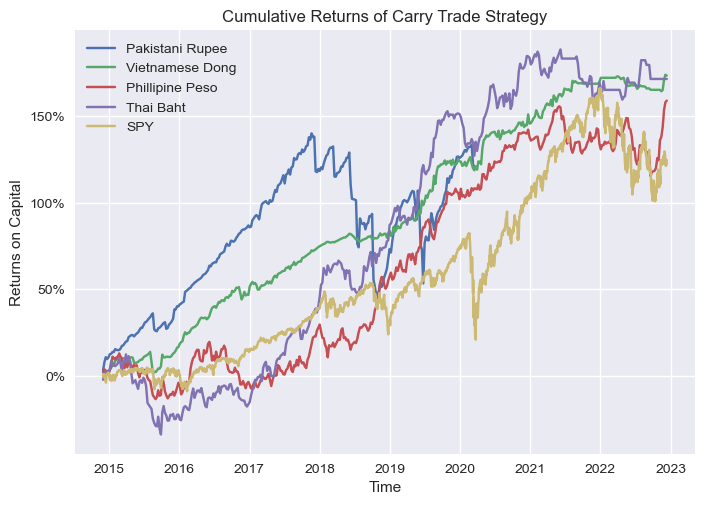

In [279]:
matplotlib.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(a.index, a['Cum Ret'], label = 'Pakistani Rupee')
ax.plot(b.index, b['Cum Ret'], label = 'Vietnamese Dong')
ax.plot(c.index, c['Cum Ret'], label = 'Phillipine Peso')
ax.plot(d.index, d['Cum Ret'], label = 'Thai Baht')
ax.plot(spy.index,spy['cum ret'], label = 'SPY')
plt.title('Cumulative Returns of Carry Trade Strategy')
ax.legend()
plt.xlabel("Time")
plt.ylabel("Returns on Capital")
formatter = ticker.PercentFormatter(xmax=1)
ax.yaxis.set_major_formatter(formatter)
plt.show()

We see that each strategy outperforms the SPY by the end of the backtesting period, and that there does appear to be a positive association. When the SPY crashes, it is observed that many of our strategies experiences falls as well. The inverse is similarly true.

## Conclusion

Overall, we implemented carry trade strategies between GBR and the currencies of Vietnam, Pakistan, the Phillipines, and Thailand, keeping cash flows in USD. In this strategies, we recieved lending accrual by holding selling bonds priced from the yield curve / swap rate, funded by a 5x leverage in UK bonds. Our returns were calculated in both gross and cumulative metrics, and these time series were analyzed for risk and return metrics. Furthermore, we compared the cumulative returns of our strategies with the cumulative returns of SPY, where we calculated both the correlation coefficient and the regression beta estimate, which provides insight on the positive relationship between our strategy returns and that of the market. I hope this was a sufficient study and description of the FX carry trades strategy. Thank you.